# Importing stuff


In [93]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import drive
from gensim.models import Word2Vec
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from collections import Counter
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Mounting data and Combining train, test and validation datasets, for splitting later on


In [94]:
# Uncomment to mount Google Drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/LiarLiarPantsOnFireData/

import os
# print(os.listdir())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/LiarLiarPantsOnFireData


## Read csv file from a directory into pandas DataFrame

In [95]:
# Modify directory if needed
train = pd.read_csv("train.tsv", delimiter = '\t')
valid = pd.read_csv("valid.tsv", delimiter = '\t')
test = pd.read_csv("test.tsv", delimiter = '\t')

In [96]:
# adding column names
column_names = [
    "id", "label", "statement", "subject", "speaker", "speaker_job_title", "state_info",
    "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts",
    "mostly_true_counts", "pants_on_fire_counts", "context"
]

train.columns = column_names
valid.columns = column_names
test.columns = column_names

In [97]:
train.head()

,id,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [98]:
valid.head()

,id,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN
1,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
2,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
3,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News
4,9416.json,false,Says when armed civilians stop mass shootings ...,guns,jim-rubens,Small business owner,New Hampshire,republican,1,1,0,1,0,"in an interview at gun shop in Hudson, N.H."


In [99]:
test.head()

,id,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
1,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
2,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
3,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video
4,5962.json,true,Over the past five years the federal governmen...,"federal-budget,pensions,retirement",brendan-doherty,NaN,Rhode Island,republican,1,2,1,1,0,a campaign website


In [100]:
# combining all data frames
df = pd.concat([train, valid, test], axis=0).reset_index(drop=True)

df.head()

,id,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


# Data Cleaning and EDA



## Check data types and null values

In [101]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12788 entries, 0 to 12787
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    12788 non-null  object 
 1   label                 12788 non-null  object 
 2   statement             12788 non-null  object 
 3   subject               12786 non-null  object 
 4   speaker               12786 non-null  object 
 5   speaker_job_title     9220 non-null   object 
 6   state_info            10037 non-null  object 
 7   party_affiliation     12786 non-null  object 
 8   barely_true_counts    12786 non-null  float64
 9   false_counts          12786 non-null  float64
 10  half_true_counts      12786 non-null  float64
 11  mostly_true_counts    12786 non-null  float64
 12  pants_on_fire_counts  12786 non-null  float64
 13  context               12657 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.4+ MB
None


In [102]:
print(df.describe())

       barely_true_counts  false_counts  half_true_counts  mostly_true_counts  \
count        12786.000000  12786.000000      12786.000000        12786.000000   
mean            11.584233     13.359768         17.186454           16.499922   
std             18.979057     24.141933         35.850604           36.168885   
min              0.000000      0.000000          0.000000            0.000000   
25%              0.000000      0.000000          0.000000            0.000000   
50%              2.000000      2.000000          3.000000            3.000000   
75%             12.000000     15.000000         13.000000           12.000000   
max             70.000000    114.000000        160.000000          163.000000   

       pants_on_fire_counts  
count          12786.000000  
mean               6.251447  
std               16.182153  
min                0.000000  
25%                0.000000  
50%                1.000000  
75%                5.000000  
max              105.000000  


## Check for missing values
- drop rows with small number of null
- for speaker_job and state, impute missing values with "Unknown"

In [103]:
print(df.isnull().sum())

id                         0
label                      0
statement                  0
subject                    2
speaker                    2
speaker_job_title       3568
state_info              2751
party_affiliation          2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  131
dtype: int64


In [104]:
# Dropping rows with small number of nulls
df = df.dropna(subset=["subject", "speaker", "party_affiliation",
                       "barely_true_counts", "false_counts", "half_true_counts",
                       "mostly_true_counts", "pants_on_fire_counts"])

# Imputing missing values for speaker_jobs state to "Unknown"
df["speaker_job_title"] = df["speaker_job_title"].fillna("unknown")
df["state_info"] = df["state_info"].fillna("unknown")
df["context"] = df["context"].fillna("unknown")

<ipython-input-104-0de4dfcef664>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["speaker_job_title"] = df["speaker_job_title"].fillna("unknown")
<ipython-input-104-0de4dfcef664>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["state_info"] = df["state_info"].fillna("unknown")
<ipython-input-104-0de4dfcef664>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [105]:
print(df.isnull().sum())
print(df.info())

id                      0
label                   0
statement               0
subject                 0
speaker                 0
speaker_job_title       0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 12786 entries, 0 to 12787
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    12786 non-null  object 
 1   label                 12786 non-null  object 
 2   statement             12786 non-null  object 
 3   subject               12786 non-null  object 
 4   speaker               12786 non-null  object 
 5   speaker_job_title     12786 non-null  object 
 6   state_info            12786 non-null  object 
 7   party_affiliation     12786 non-null  object 
 8   bare

## Normalising string columns

### through lowering of cases and removing leading and lagging spaces


In [106]:
def clean_text(text):
    if isinstance(text, str):
        return text.lower().strip()
    return text

In [107]:
df = df.applymap(clean_text)
df.head()

<ipython-input-107-2efc9cd6d813>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_text)


,id,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,10540.json,half-true,when did the decline of coal start? it started...,"energy,history,job-accomplishments",scott-surovell,state delegate,virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"hillary clinton agrees with john mccain ""by vo...",foreign-policy,barack-obama,president,illinois,democrat,70.0,71.0,160.0,163.0,9.0,denver
2,1123.json,false,health care reform legislation is likely to ma...,health-care,blog-posting,unknown,unknown,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,the economic turnaround started at the end of ...,"economy,jobs",charlie-crist,unknown,florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on cnn
4,12465.json,true,the chicago bears have had more starting quart...,education,robin-vos,wisconsin assembly speaker,wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


## Examining Unique Values in Categorical Features
- to understand how many unique values in each categorical column

In [108]:
categorical_columns = ["label", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "context"]
categorical_uniques_sum = {col: df[col].nunique() for col in categorical_columns}
categorical_uniques_sum

{'label': 6,
 'subject': 4534,
 'speaker': 3308,
 'speaker_job_title': 1268,
 'state_info': 68,
 'party_affiliation': 24,
 'context': 4991}

In [109]:
categorical_uniques = {col: df[col].unique() for col in categorical_columns}
categorical_uniques

{'label': array(['half-true', 'mostly-true', 'false', 'true', 'barely-true',
        'pants-fire'], dtype=object),
 'subject': array(['energy,history,job-accomplishments', 'foreign-policy',
        'health-care', ..., 'animals,candidates-biography',
        'bipartisanship,congress,foreign-policy,history',
        'environment,government-efficiency'], dtype=object),
 'speaker': array(['scott-surovell', 'barack-obama', 'blog-posting', ...,
        'hugh-fitzsimons', 'menendez-facts', 'mackubin-thomas-owens'],
       dtype=object),
 'speaker_job_title': array(['state delegate', 'president', 'unknown', ...,
        'u.s. supreme court justice', 'rancher',
        'senior fellow, foreign policy research institute'], dtype=object),
 'state_info': array(['virginia', 'illinois', 'unknown', 'florida', 'wisconsin', 'texas',
        'new jersey', 'vermont', 'massachusetts', 'maryland',
        'washington, d.c.', 'oregon', 'new york', 'california', 'missouri',
        'rhode island', 'west virgi

## One-hot encoding for the 'label' column
### Examining the unique values for the label column, there are 6 unique values: 'half-true', 'mostly-true', 'false', 'true', 'barely-true','pants-fire'.

### However, there is no 'true_count' column in the dataset. Therefore, we use one-hot encoding to take into account the statements which has the label 'true'

In [110]:
df_labels = pd.get_dummies(df["label"], prefix="label")
df = pd.concat([df, df_labels], axis=1)
df.head()

,id,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,label_barely-true,label_false,label_half-true,label_mostly-true,label_pants-fire,label_true
0,10540.json,half-true,when did the decline of coal start? it started...,"energy,history,job-accomplishments",scott-surovell,state delegate,virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,False,False,True,False,False,False
1,324.json,mostly-true,"hillary clinton agrees with john mccain ""by vo...",foreign-policy,barack-obama,president,illinois,democrat,70.0,71.0,160.0,163.0,9.0,denver,False,False,False,True,False,False
2,1123.json,false,health care reform legislation is likely to ma...,health-care,blog-posting,unknown,unknown,none,7.0,19.0,3.0,5.0,44.0,a news release,False,True,False,False,False,False
3,9028.json,half-true,the economic turnaround started at the end of ...,"economy,jobs",charlie-crist,unknown,florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on cnn,False,False,True,False,False,False
4,12465.json,true,the chicago bears have had more starting quart...,education,robin-vos,wisconsin assembly speaker,wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,False,False,False,False,False,True


## Cleaning up the 'party_affiliation' column

## We keep major parties such as republican and democrat and group other categories into broader categories

In [111]:
df['party_affiliation'].value_counts()

,count
party_affiliation,
republican,5662
democrat,4137
none,2181
organization,264
independent,180
newsmaker,64
libertarian,51
journalist,49
activist,45


In [112]:
# consolidating party affiliations

def simplify_party(party):
    if not isinstance(party, str):
        return "other"

    party = party.lower()

    if party in ["republican", "democrat", "independent", "libertarian", "green", "constitution-party"]:
        return party
    elif "tea-party" in party or "ocean-state-tea-party-action" in party:
        return "tea-party"
    elif "journalist" in party or "columnist" in party or "talk-show-host" in party:
        return "media"
    elif "organization" in party or "government-body" in party:
        return "organization"
    elif "activist" in party or "labor-leader" in party:
        return "activist"
    elif "business-leader" in party:
        return "business"
    elif "education-official" in party:
        return "education"
    else:
        return "other"

df["party_affiliation"] = df["party_affiliation"].apply(simplify_party)
df['party_affiliation'].value_counts()
# one hot encoding for ml models and label encoding for trees?

,count
party_affiliation,
republican,5662
democrat,4137
other,2274
organization,266
independent,180
media,125
activist,60
libertarian,51
business,11


## Cleaning up the 'state_info' column

### We make sure that the same states are labelled the same way and grouped irrelevant states such as 'Qatar' under 'foreign'

In [113]:
print(df['state_info'].value_counts().to_string())

state_info
unknown                                              2752
texas                                                1258
florida                                              1237
wisconsin                                             902
new york                                              831
illinois                                              695
ohio                                                  589
georgia                                               553
virginia                                              513
rhode island                                          454
oregon                                                310
new jersey                                            305
massachusetts                                         256
arizona                                               228
california                                            184
washington, d.c.                                      156
vermont                                               117
pen

In [114]:
df['state_info'] = df['state_info'].str.lower().str.strip()
state_corrections = { #replacing entries with typos or redundancies
    'washington, d.c.': 'district of columbia',
    'washington dc': 'district of columbia',
    'washington d.c.': 'district of columbia',
    'massachusetts ': 'massachusetts',
    'washington state': 'washington',
    'virgina': 'virginia',
    'virgiia': 'virginia',
    'tennesse': 'tennessee',
    'tex': 'texas',
    'pa - pennsylvania': 'pennsylvania',
    'the united states': 'usa',
    'russia': 'foreign',
    'united kingdom': 'foreign',
    'qatar': 'foreign',
    'china': 'foreign',
    'atlanta': 'georgia'
}

df['state_info'] = df['state_info'].replace(state_corrections)
df = df[df['state_info'] != "virginia director, coalition to stop gun violence"]
print(df['state_info'].value_counts().to_string()) #to avoid truncated output

state_info
unknown                 2752
texas                   1259
florida                 1237
wisconsin                902
new york                 831
illinois                 695
ohio                     589
georgia                  554
virginia                 517
rhode island             454
oregon                   310
new jersey               305
massachusetts            256
arizona                  228
california               184
district of columbia     174
vermont                  117
pennsylvania             113
new hampshire            108
arkansas                 103
kentucky                  98
tennessee                 89
maryland                  86
delaware                  84
alaska                    81
minnesota                 75
north carolina            72
nevada                    58
indiana                   52
missouri                  48
south carolina            39
new mexico                37
colorado                  33
louisiana                 33
mic

## Preprocessing for "statement" column

### lowercasing and removal of spaces were already conducted

###  here, we process the statement through: removal of special characters and punctuation, tokenization, removal of stopwords, lemmatization

In [116]:
# Ensuring that all statements are strings
df.loc[:, 'statement'] = df['statement'].fillna('')
df.loc[:, 'statement'] = df['statement'].astype(str)

# Remove special characters and punctuation
df.loc[:, 'statement'] = df['statement'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)

# Tokenization (by breaking the text into words)
df.loc[:, 'statement'] = df['statement'].apply(word_tokenize)

# Stopword removal
stop_words = set(stopwords.words('english')) | {"percent", "say", "state", "year", "people", "says"}
df.loc[:, 'statement'] = df['statement'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization (reduce words to their root form)
lemmatizer = WordNetLemmatizer()
df.loc[:, 'statement'] = df['statement'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Joining the tokens back
df.loc[:, 'statement'] = df['statement'].apply(lambda x: ' '.join(x))

df.head()

,id,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,label_barely-true,label_false,label_half-true,label_mostly-true,label_pants-fire,label_true
0,10540.json,half-true,decline coal start started natural gas took st...,"energy,history,job-accomplishments",scott-surovell,state delegate,virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,False,False,True,False,False,False
1,324.json,mostly-true,hillary clinton agrees john mccain voting give...,foreign-policy,barack-obama,president,illinois,democrat,70.0,71.0,160.0,163.0,9.0,denver,False,False,False,True,False,False
2,1123.json,false,health care reform legislation likely mandate ...,health-care,blog-posting,unknown,unknown,other,7.0,19.0,3.0,5.0,44.0,a news release,False,True,False,False,False,False
3,9028.json,half-true,economic turnaround started end term,"economy,jobs",charlie-crist,unknown,florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on cnn,False,False,True,False,False,False
4,12465.json,true,chicago bear starting quarterback last 10 tota...,education,robin-vos,wisconsin assembly speaker,wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,False,False,False,False,False,True


# Visualisations

## Checking label distribution:
- This helps use to understand class imbalance and whether there is a need for resampling techniques

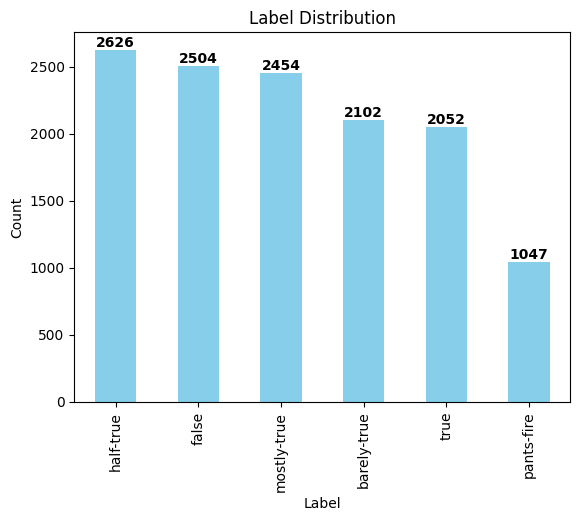

In [117]:
ax = df['label'].value_counts().plot(kind='bar', color='skyblue')

plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

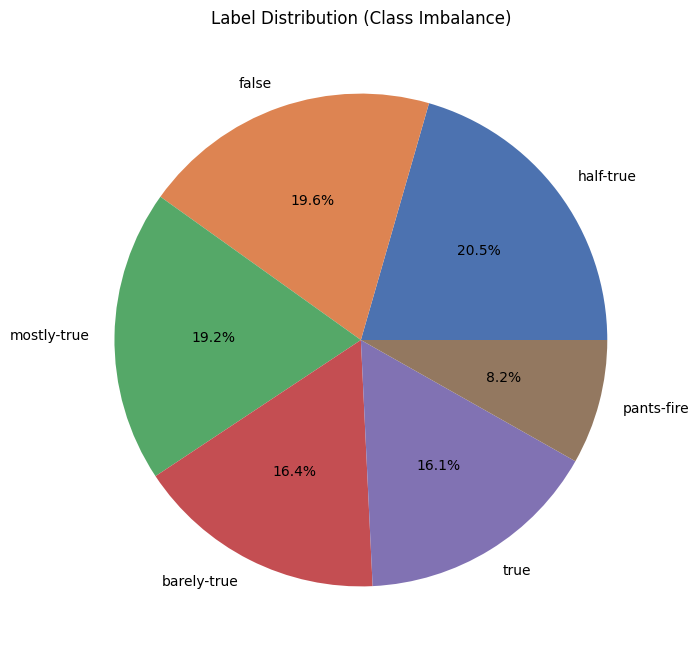

In [118]:
# Visualize label distribution (for classification)
plt.figure(figsize=(8, 8))
colors = sns.color_palette('deep')[0:6]
df['label'].value_counts().plot(kind='pie', colors = colors, autopct='%1.1f%%')

plt.title('Label Distribution (Class Imbalance)')
plt.ylabel('')
plt.show()

## Check subject(s) distribution

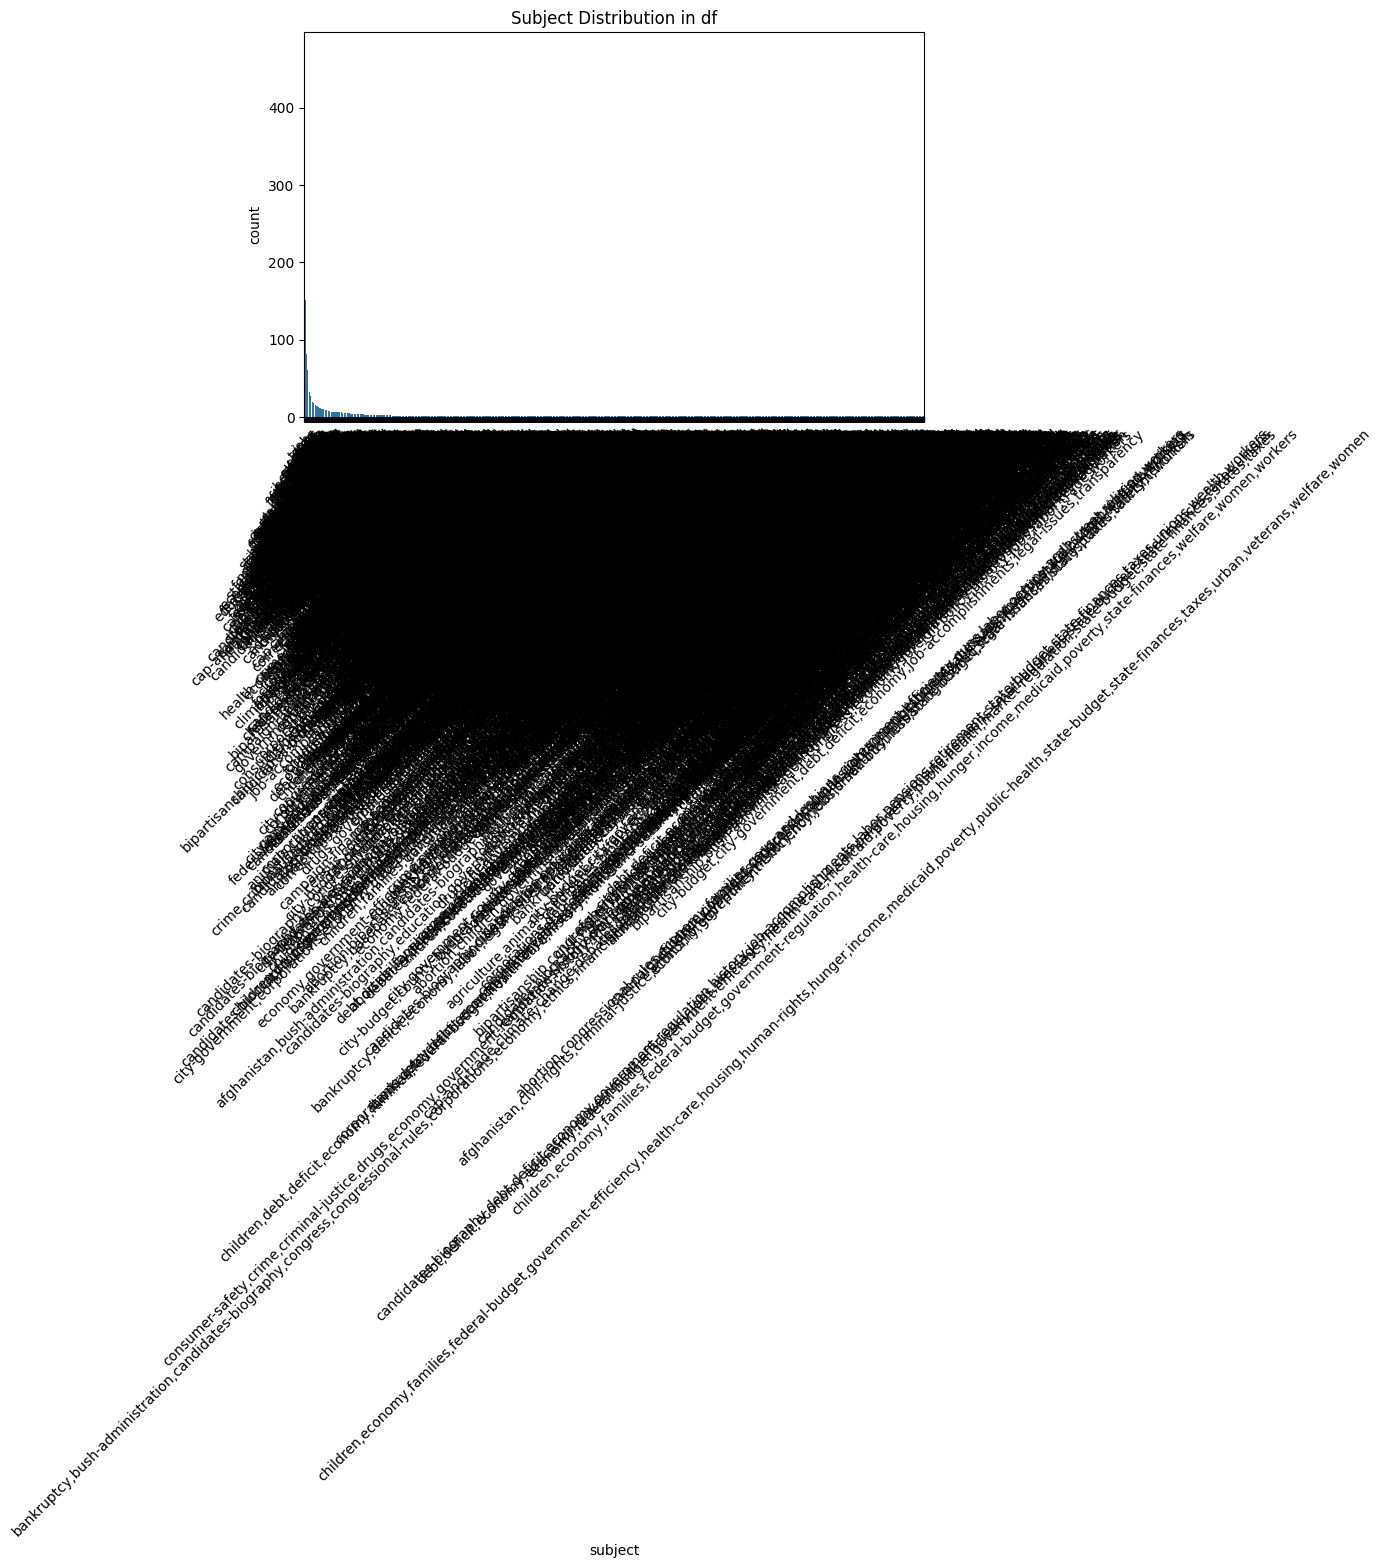

In [119]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="subject", order=df["subject"].value_counts().index)
plt.title("Subject Distribution in df")
plt.xticks(rotation=45)
plt.show()

### only show top 20 subjects

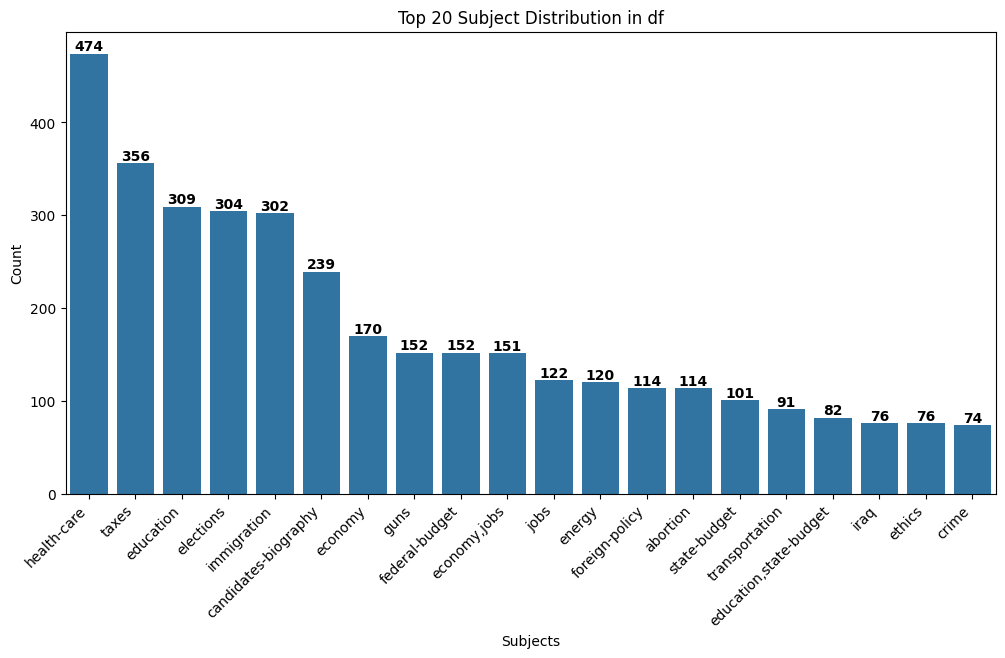

In [120]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x="subject", order=df["subject"].value_counts().nlargest(20).index)

plt.title("Top 20 Subject Distribution in df")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Subjects")
plt.ylabel("Count")

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', weight='bold')

plt.show()

## Check Speaker Distribution

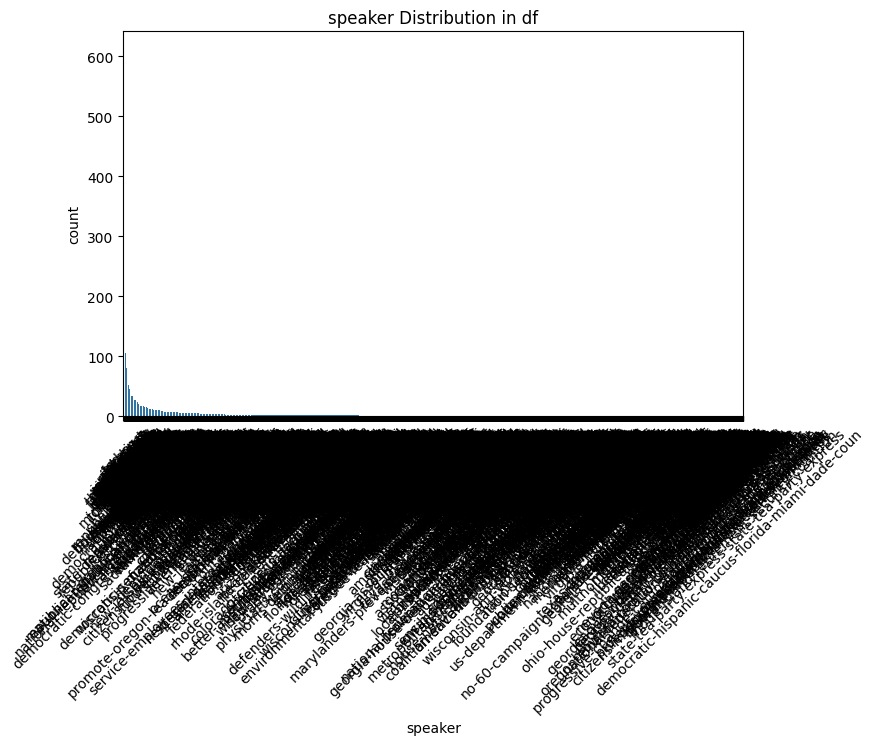

In [121]:
plt.figure(figsize=(8,5))

sns.countplot(data=df, x="speaker", order=df["speaker"].value_counts().index)
plt.title("speaker Distribution in df")
plt.xticks(rotation=45)

plt.show()

### Top 20 speakers

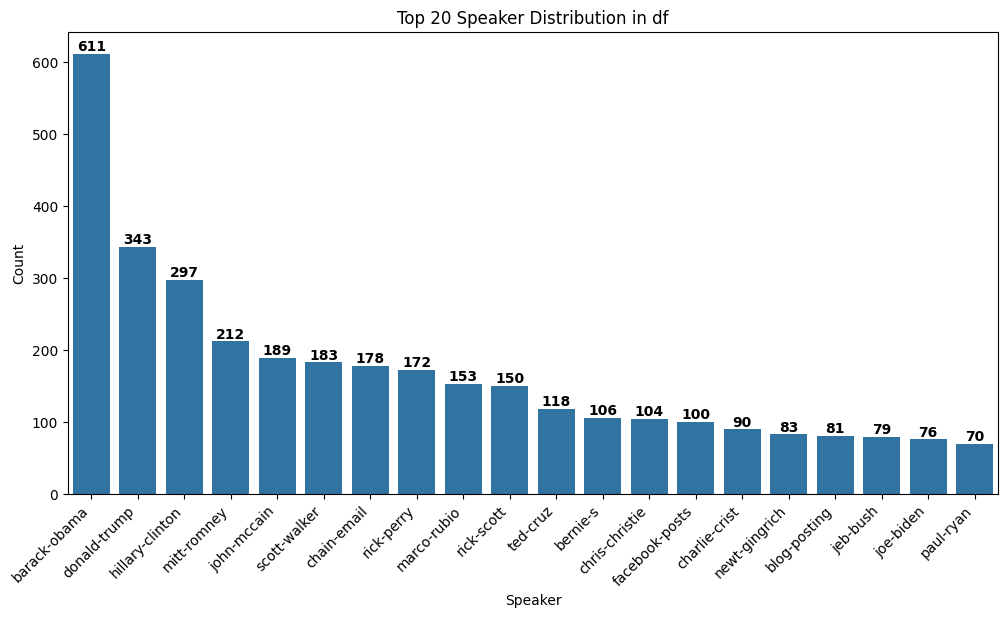

In [122]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x="speaker", order=df["speaker"].value_counts().nlargest(20).index)

plt.title("Top 20 Speaker Distribution in df")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Speaker")
plt.ylabel("Count")

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', weight='bold')

plt.show()

### Visualise the distribution of labels for the statements made by each speaker



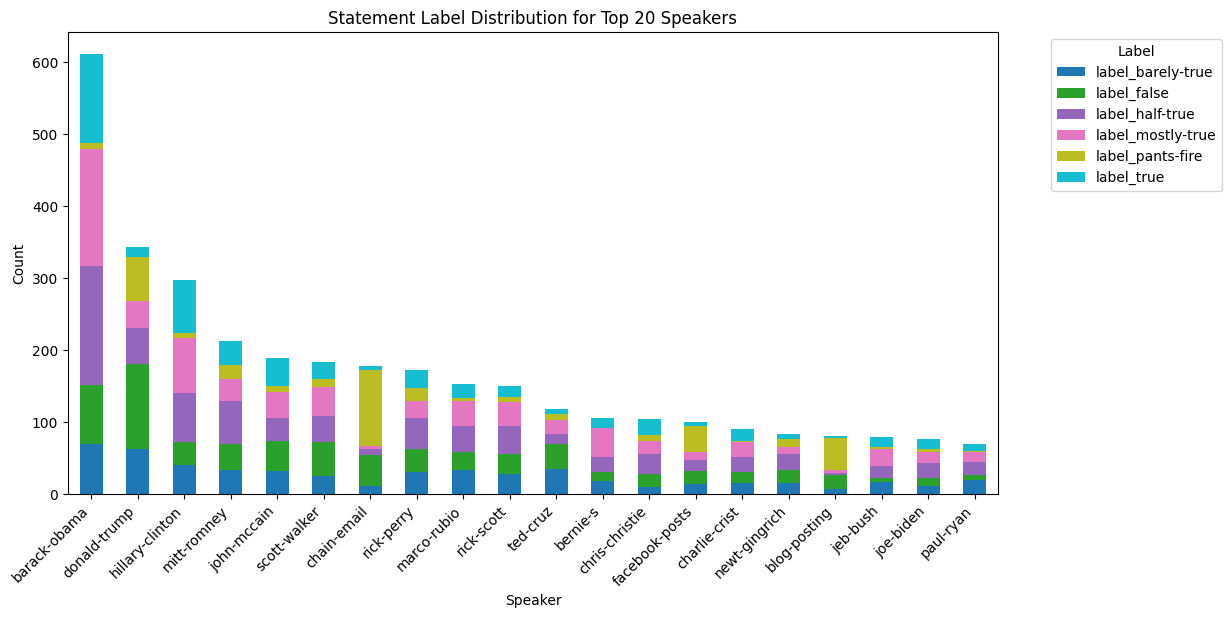

In [123]:
# Get the top 20 speakers by count
top_20_speakers = df["speaker"].value_counts().nlargest(20).index

# Filter the dataset to only include these speakers
df_top_speakers = df[df["speaker"].isin(top_20_speakers)]

# Aggregate the label counts for each speaker
label_columns = ["label_barely-true", "label_false", "label_half-true", "label_mostly-true", "label_pants-fire", "label_true"]
df_speaker_labels = df_top_speakers.groupby("speaker")[label_columns].sum()

# Order speakers by total statement count in descending order
df_speaker_labels["total_statements"] = df_speaker_labels.sum(axis=1)
df_speaker_labels = df_speaker_labels.sort_values(by="total_statements", ascending=False).drop(columns=["total_statements"])

# Plot stacked bar chart
df_speaker_labels.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")

plt.title("Statement Label Distribution for Top 20 Speakers")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

### Out of the top 20 speakers, we visualise the top 5 speakers with "True" statements and "False statements" (in terms of percentage)

In [124]:
# Compute percentages for "true" and "false" statements
df_speaker_labels["true_percentage"] = df_speaker_labels["label_true"] / df_speaker_labels.sum(axis=1) * 100
df_speaker_labels["false_percentage"] = df_speaker_labels["label_false"] / df_speaker_labels.sum(axis=1) * 100

# Get top 5 speakers with the highest percentage of "true" statements
top_5_true_speakers = df_speaker_labels.nlargest(5, "true_percentage")[["true_percentage", "label_true"]]

# Get top 5 speakers with the highest percentage of "false" statements
top_5_false_speakers = df_speaker_labels.nlargest(5, "false_percentage")[["false_percentage", "label_false"]]

# Function to retrieve additional speaker details
def get_speaker_details(df, speakers):
    return df[df["speaker"].isin(speakers)].groupby("speaker").first()[["subject", "speaker_job_title", "state_info", "party_affiliation"]]

# Merge with speaker details
top_5_true_speakers = top_5_true_speakers.merge(get_speaker_details(df, top_5_true_speakers.index), left_index=True, right_index=True)
top_5_false_speakers = top_5_false_speakers.merge(get_speaker_details(df, top_5_false_speakers.index), left_index=True, right_index=True)

# Display results
print("Top 5 Speakers with the Highest Percentage of 'True' Statements:")
top_5_true_speakers

Top 5 Speakers with the Highest Percentage of 'True' Statements:


,true_percentage,label_true,subject,speaker_job_title,state_info,party_affiliation
speaker,,,,,,
hillary-clinton,24.579125,73,economy,presidential candidate,new york,democrat
chris-christie,21.153846,22,pensions,governor of new jersey,new jersey,republican
john-mccain,20.634921,39,elections,u.s. senator,arizona,republican
barack-obama,20.130933,123,foreign-policy,president,illinois,democrat
charlie-crist,17.777778,16,"economy,jobs",unknown,florida,democrat


In [125]:
print("\nTop 5 Speakers with the Highest Percentage of 'False' Statements:")
top_5_false_speakers


Top 5 Speakers with the Highest Percentage of 'False' Statements:


,false_percentage,label_false,subject,speaker_job_title,state_info,party_affiliation
speaker,,,,,,
donald-trump,33.709649,117,immigration,president-elect,new york,republican
ted-cruz,27.434354,34,"consumer-safety,corrections-and-updates,govern...",senator,texas,republican
scott-walker,24.032524,47,"government-regulation,jobs,poverty,welfare",milwaukee county executive,wisconsin,republican
chain-email,23.708338,43,"health-care,immigration",unknown,unknown,other
blog-posting,22.431132,19,health-care,unknown,unknown,other


## Check job title distribution

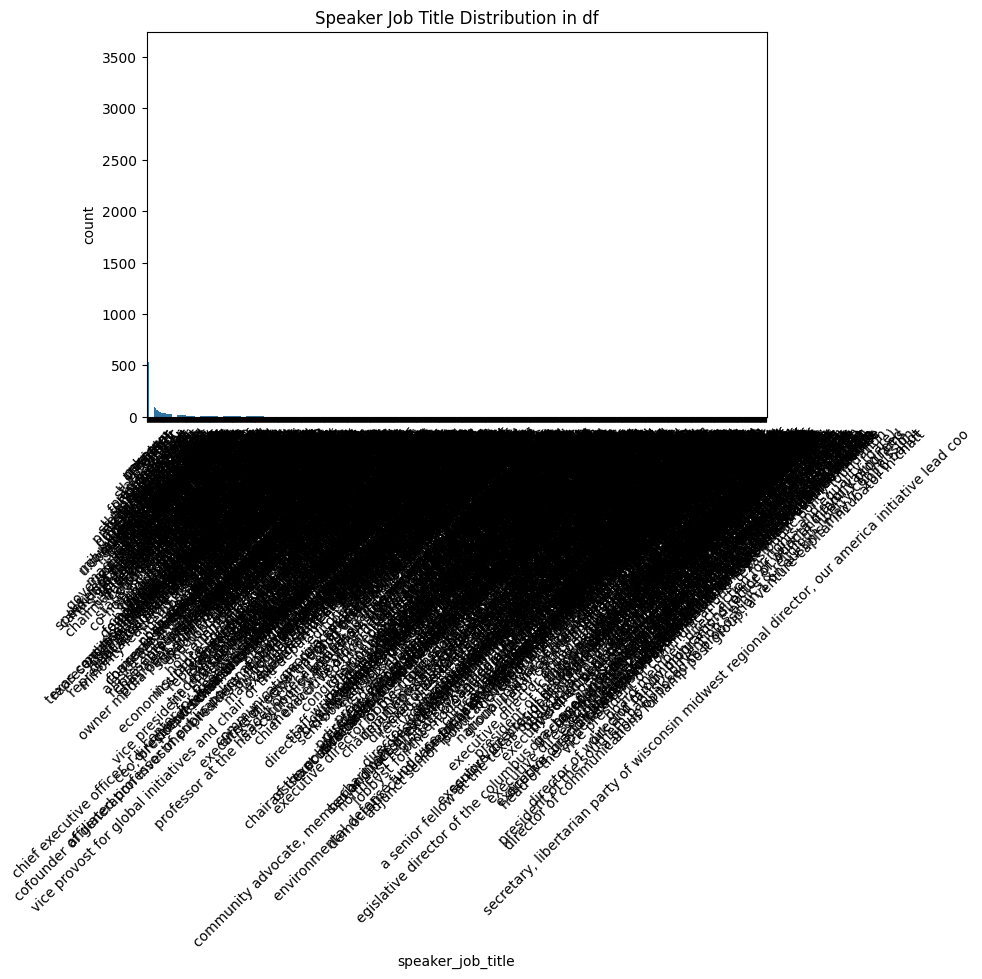

In [126]:
plt.figure(figsize=(8,5))

sns.countplot(data=df, x="speaker_job_title", order=df["speaker_job_title"].value_counts().index)
plt.title("Speaker Job Title Distribution in df")
plt.xticks(rotation=45)

plt.show()

### show top 20 job title distributions

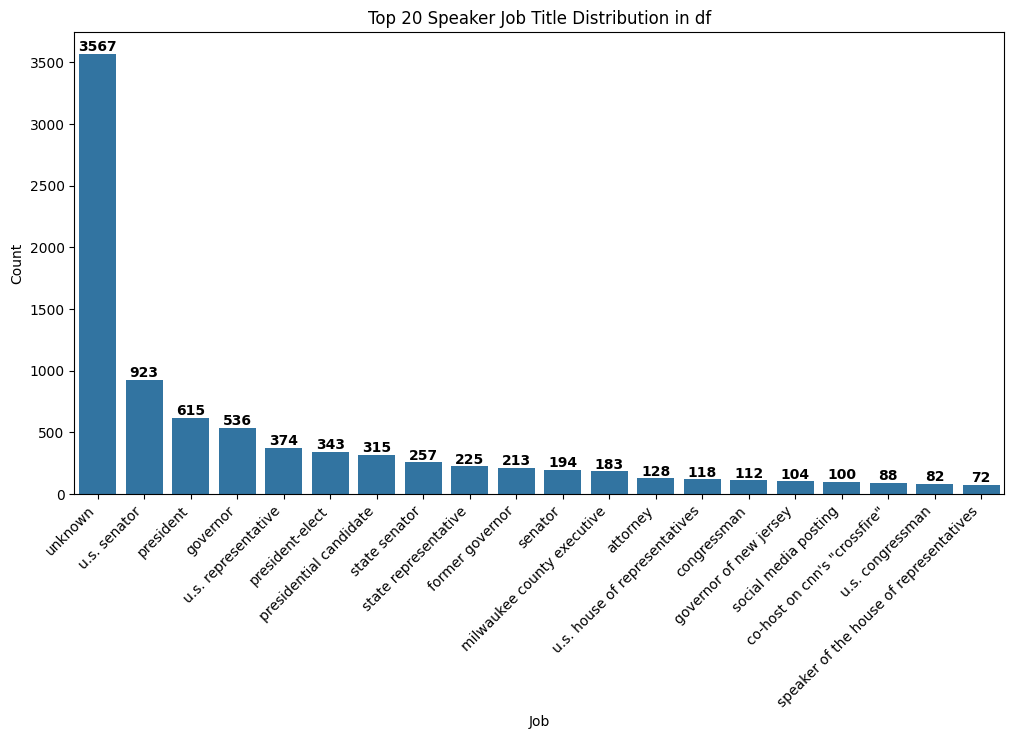

In [127]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x="speaker_job_title", order=df["speaker_job_title"].value_counts().nlargest(20).index)

plt.title("Top 20 Speaker Job Title Distribution in df")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Job")
plt.ylabel("Count")

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', weight='bold')

plt.show()

## Check state info distribution

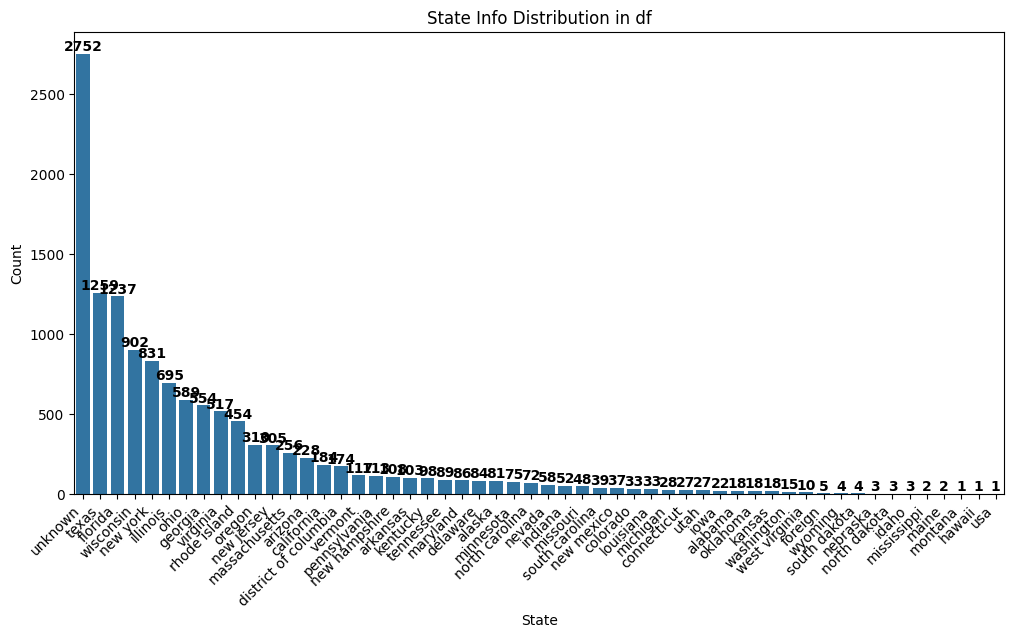

In [128]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x="state_info", order=df["state_info"].value_counts().index)

plt.title("State Info Distribution in df")
plt.xticks(rotation=45, ha="right")
plt.xlabel("State")
plt.ylabel("Count")

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', weight='bold')

plt.show()

## Check party affliation distribution

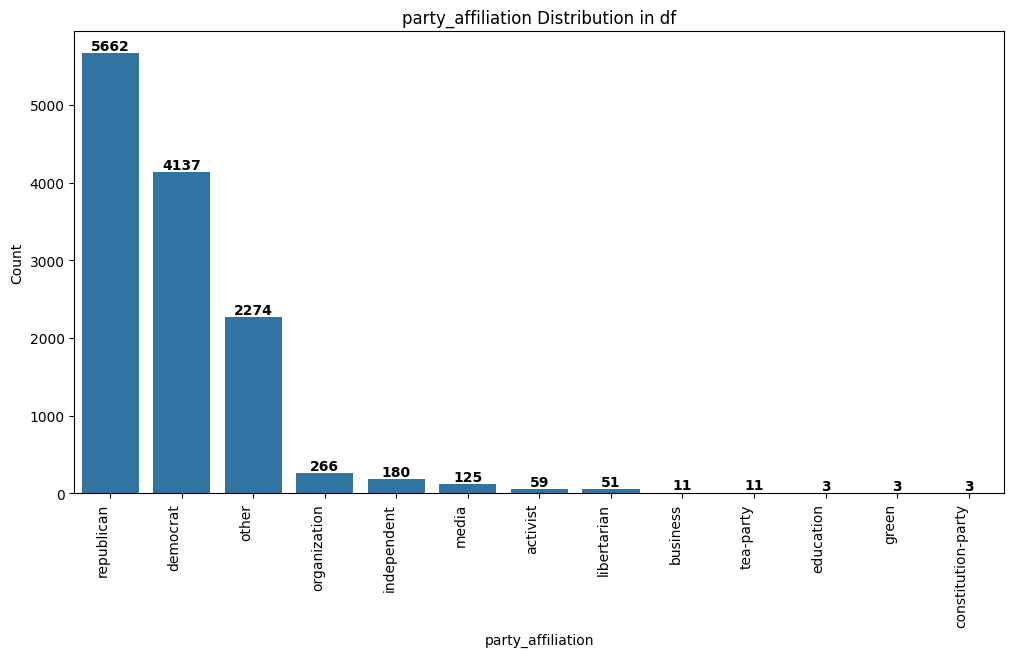

In [129]:
plt.figure(figsize=(12, 6))

# Order states in descending count order
order = df["party_affiliation"].value_counts().index

# Create count plot
ax = sns.countplot(data=df, x="party_affiliation", order=order)

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', weight='bold')

# Adjust title and labels
plt.title("party_affiliation Distribution in df", fontsize=12)
plt.xticks(rotation=90, ha="right")
plt.ylabel("Count")

# Show the plot
plt.show()

## Check context distribution

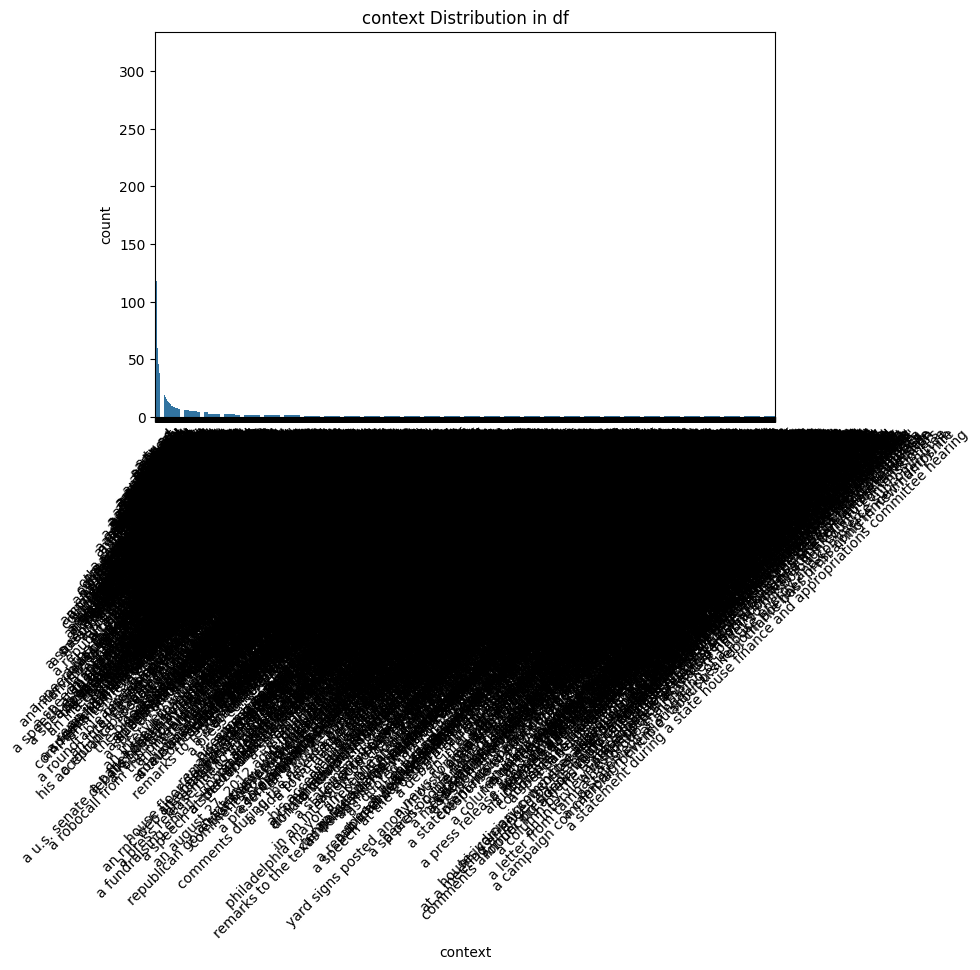

In [78]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="context", order=df["context"].value_counts().index)
plt.title("context Distribution in df")
plt.xticks(rotation=45)
plt.show()

## Word cloud for each label

In [132]:
additional_stopwords = {"ha", "wa"}

labels = df['label'].unique()

for label in labels:
    # Filter the data for the current label
    text = ' '.join(df[df['label'] == label]['statement'])

    # Remove additional stopwords
    filtered_text = ' '.join([word for word in text.split() if word not in additional_stopwords])

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

    # Plot the WordCloud for the current label
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Label: {label}')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Feature Engineering Ideas
- encodings/ embeddings for "subject", "speaker_job_title", party_affiliation", "context"
- tf-idf and word embeddings for statement for text and sentiment analysis

# Git stuff

In [176]:
!git status

On branch eda
Your branch is ahead of 'origin/eda' by 1 commit.
  (use "git push" to publish your local commits)

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   eda (1).ipynb

